In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [5]:
llm.invoke("hi hello how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 13, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C8qSvf9GtzMKYgtEi2gFPcfUGd0v2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--b574e17a-7022-43d7-8bf4-d4c5a340daf5-0', usage_metadata={'input_tokens': 13, 'output_tokens': 27, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langgraph.types import Command

In [6]:
from langgraph.prebuilt import create_react_agent

In [8]:
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     Name:str
#     age:int
#     DOB:int

In [7]:
def add_number(state):
    result=state["num1"]+state["num2"]
    print(f"addition is {result}")
    return Command(goto="multiply",update={"sum":result})

In [8]:
state={"num1":10,"num2":20}

In [9]:
add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

### Creating one dummy multiagent

it is for network/collab multiagent

In [10]:
from langchain_core.tools import tool

In [11]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [12]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [13]:
llm_with_tool=llm.bind_tools([transfer_to_addition_expert])

In [14]:
response=llm_with_tool.invoke("hi")

In [15]:
response.content

'Hello! How can I assist you today?'

In [16]:
response.tool_calls

[]

In [17]:
response=llm_with_tool.invoke("what is 2+2?")

In [98]:
response.content

''

In [99]:
response.tool_calls

[{'name': 'transfer_to_addition_expert',
  'args': {},
  'id': 'call_efUFRfP7dDZYAYVdr6qQ5O0q',
  'type': 'tool_call'}]

In [34]:
system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

In [35]:
messages = [{"role": "system", "content": system_prompt}] + ["can you tell me the addition of 2 and 2?"]

In [36]:
messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

In [29]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [101]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [102]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [103]:
graph=StateGraph(MessagesState)

In [104]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)

In [105]:
graph.add_edge(START, "additional_expert")

In [106]:
app=graph.compile()

In [107]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='504276e8-c619-4691-ac26-295af5c6984d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HyFaM2WWuNu6xLxTB8bbQf0X', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 86, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bl74ZmahG9pCAdfp8KYhPKfG6oULJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d9308028-8f59-44a9-ba7f-df9bd62647dd-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}

## With realtime tool

In [18]:
from langchain_community.tools import DuckDuckGoSearchRun

In [19]:
# search_tool=DuckDuckGoSearchRun()

import os
from langchain_community.tools.tavily_search import TavilySearchResults
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)

In [20]:
search_tool.invoke("who is a current pm of uk?")

[{'title': 'Prime Minister - GOV.UK',
  'url': 'https://www.gov.uk/government/ministers/prime-minister',
  'content': 'The Prime Minister is the leader of His Majesty’s Government and is ultimately responsible for the policy and decisions of the government.\n\nAs leader of the UK government the Prime Minister also:\n\n## Current role holder\n\n### The Rt Hon Sir Keir Starmer KCB KC MP\n\nSir Keir Starmer became Prime Minister on 5 July 2024.\n\n## Education [...] Keir attended Reigate Grammar School, before studying Law at the University of Leeds. He went on to do postgraduate studies at the University of Oxford, receiving a Bachelor of Civil Law (BCL) degree.\n\n## Political Career\n\nKeir was elected a Member of Parliament for Holborn and St Pancras in May 2015. He was elected leader of the Labour Party in April 2020.\n\n## Career before politics [...] Find out more about previous holders of this role in our past Prime Ministers section.\n\n## Announcements\n\n## Subscriptions\n\n## 

In [21]:
from langchain_experimental.utilities import PythonREPL

In [22]:
repl=PythonREPL()

In [23]:
code = """
x = 5
y = x * 2
print(y)
"""

In [117]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [24]:
from typing import Annotated

In [25]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    

In [26]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x0000025A5A74EDE0>)

In [27]:
print(python_repl_tool.invoke(code))

Python REPL can execute arbitrary code. Use with caution.


Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [28]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [29]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [30]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [38]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState,StateGraph, START,END
from typing_extensions import Literal

In [32]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

result=[humanmesssage
aimessgae
toolmessage
aimessage
toolmessage
aimessage]

In [39]:
#agent1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    
    
    result=research_agent.invoke(state)
    
    # result=[messages:{humanmesssage
    #                 aimessgae
    #                 toolmessage
    #                 aimessage
    #                 toolmessage
    #                 aimessage}]
    
    goto=get_next_node(result["messages"][-1],"chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [40]:
agent1(human1)-->agent2(human2)

SyntaxError: invalid syntax (2825819459.py, line 1)

AIMessage(content="Here are the UK GDP figures for the past three years:\n\n- **2021**: $3,141.51 billion\n- **2022**: $3,088.84 billion\n- **2023**: $3,340.03 billion\n\nLet's create a line chart with this data. I'll pass these figures to my colleague to make the chart.", additional_kwargs={'tool_calls': [{'id': 'call_jFcUWkL9Zq54uWKBe5rMC9Yh', 'function': {'arguments': '{"query":"UK GDP 2023 2022 2021 line chart"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 106, 'prompt_tokens': 9945, 'total_tokens': 10051, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 7936}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bl84FVwNUMyu4khQNXpftP508oUlR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d068c020-31cb-463f-878a-9a83f88bf9d5-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP 2023 2022 2021 line chart'}, 'id': 'call_jFcUWkL9Zq54uWKBe5rMC9Yh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 9945, 'output_tokens': 106, 'total_tokens': 10051, 'input_token_details': {'audio': 0, 'cache_read': 7936}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [41]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [42]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

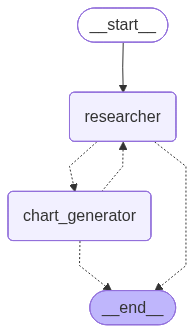

In [43]:
workflow.compile()

In [44]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-97LQrOtNCzQ5z4PU3BOL6nJI on tokens per min (TPM): Limit 30000, Used 30000, Requested 156. Please try again in 312ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

code="""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()"""

In [164]:
code="""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()"""

In [163]:
print("""import matplotlib.pyplot as plt\\n\\n# Data for the UK GDP over the past 3 years\\nyears = [2019, 2020, 2021]\\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \\n\\ndef create_line_chart(years, gdp_values):\\n    plt.figure(figsize=(10, 6))\\n    plt.plot(years, gdp_values, marker=\'o\', color=\'b\', linestyle=\'-\', linewidth=2)\\n    plt.title(\'UK GDP Over the Past 3 Years\')\\n    plt.xlabel(\'Year\')\\n    plt.ylabel(\'GDP (in billion $)\')\\n    plt.grid(True)\\n    plt.tight_layout()\\n    plt.show()""")

import matplotlib.pyplot as plt\n\n# Data for the UK GDP over the past 3 years\nyears = [2019, 2020, 2021]\ngdp_values = [2851.41, 2697.81, 3141.51]  # in billion $ \n\ndef create_line_chart(years, gdp_values):\n    plt.figure(figsize=(10, 6))\n    plt.plot(years, gdp_values, marker='o', color='b', linestyle='-', linewidth=2)\n    plt.title('UK GDP Over the Past 3 Years')\n    plt.xlabel('Year')\n    plt.ylabel('GDP (in billion $)')\n    plt.grid(True)\n    plt.tight_layout()\n    plt.show()


In [ ]:
retriver_tool=documents

def fun(document):
    calcualtion

In [ ]:
llm_with_bind_tool=llm.bind_tools(fun)

In [ ]:
llm_with_bind_tool.invoke(query)

In [ ]:
tool_calls

{
    tool_name(function name)
    
}

In [ ]:
dict={
   funcation_name: fun
   function_name2: fun2
    
}

In [ ]:
func=dict[tool_calls.tool_name]

In [ ]:
func(docu)